In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
import collections
import einops
import matplotlib.pyplot as plt
import math
import numpy as np
import torch
import torch as t
from torch import nn
import transformers
from trl.gpt2 import GPT2HeadWithValueModel, respond_to_batch
from trl.ppo import PPOTrainer
from typing import Tuple, List, Dict
from tqdm import tqdm
import json
import random
import time

from minigpt_utils import get_minigpt, MiniGPT
from days.utils import *

In [ ]:
DEVICES = [f"cuda:{i}" for i in range(8)]

In [ ]:
tokenizer = transformers.GPT2Tokenizer.from_pretrained("gpt2")
tokenizer._add_tokens(["[BEGIN]", "[END]"])
tokenizer.pad_token = "[END]"
tokenizer.eos_token = "[END]"

In [ ]:
gen_model = GPT2HeadWithValueModel.from_pretrained("gpt2")

Some weights of GPT2HeadWithValueModel were not initialized from the model checkpoint at gpt2 and are newly initialized: ['h.0.attn.masked_bias', 'h.1.attn.masked_bias', 'h.2.attn.masked_bias', 'h.3.attn.masked_bias', 'h.4.attn.masked_bias', 'h.5.attn.masked_bias', 'h.6.attn.masked_bias', 'h.7.attn.masked_bias', 'h.8.attn.masked_bias', 'h.9.attn.masked_bias', 'h.10.attn.masked_bias', 'h.11.attn.masked_bias', 'v_head.summary.bias', 'lm_head.weight', 'v_head.summary.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# Generating probabilities

In [ ]:
solo_logits = {}
for token in range(tokenizer.vocab_size):
    sentence = t.tensor([[tokenizer.bos_token_id, token]], dtype=t.long)
    logits = gen_model(sentence)[0]
    solo_logits[token] = t.softmax(logits, dim=2)[0, 0, token].detach().item()

In [ ]:
len(solo_logits)

50257

In [ ]:
with open("gpt2_p_token_after_bos.txt", 'w') as f:
    json.dump(solo_logits, f)

In [ ]:
with open("gpt2_p_token_after_bos.txt") as f:
    target = json.load(f)

In [ ]:
target_dict = target

In [ ]:
target = t.tensor([target_dict[str(k)] for k in range(tokenizer.vocab_size)])

# Try training with restricted vocab

In [ ]:
top1000 = t.topk(target, k=1000).indices

In [ ]:
top1000_set = set(top1000.numpy())

In [ ]:
def mask(logits, allowed):
    logits[:,~allowed] = -t.inf

In [ ]:
def generate(model, queries, allowed, txt_len=20, top_k=0, top_p=1.0):
    """Sample text from language model."""
    input_ids = queries
    for i in range(txt_len):
        # Get Logits
        outputs = model(input_ids)
        next_token_logits = outputs[0][:, -1, :] # start from next token
        mask(next_token_logits, allowed) # remove verboten vocab
        next_token_logits = transformers.top_k_top_p_filtering(next_token_logits, top_k=top_k, top_p=top_p)
        # Sample
        probs = t.nn.functional.softmax(next_token_logits, dim=-1)
        probs[t.isnan(probs).nonzero()] = 0
        next_token = torch.multinomial(probs, num_samples=1).squeeze(1)
        input_ids = torch.cat([input_ids, next_token.unsqueeze(-1)], dim=-1)
    return input_ids[:, -txt_len:]

In [ ]:
def train(
    gen_model,
    ref_model,
    ppo_config,
    vocab,
    reward_fn,
    device,
    gen_len:int = 20,
    top_p:float = 1.0,
    num_batches:int = 2,
):
    ppo_trainer = PPOTrainer(gen_model, ref_model, **ppo_config)

    # encode a query
    # query_txt = "This morning I went to the "
    query_tensor = (t.tensor([tokenizer.bos_token_id], dtype=t.long, device=device)
                    .unsqueeze(0)
                    .repeat(ppo_config['batch_size'], 1))
        
    batch_info = []
    allowed = t.isin(t.arange(tokenizer.vocab_size, device=device), vocab)
    for batch in tqdm(range(num_batches)):
        # get model response
        with t.no_grad():
            response_tensor = generate(gen_model, query_tensor, allowed, txt_len=gen_len, top_p=top_p)

        reward = reward_fn(response_tensor)

        # train model with ppo
        train_stats = ppo_trainer.step(query_tensor, response_tensor, reward)
        batch_info.append(train_stats)

    return batch_info

In [ ]:
def silly_reward(pos_tokens: t.Tensor): # b, seq_len -> b
    return t.max(pos_tokens, dim=1).values/tokenizer.vocab_size

In [ ]:
########## This cell runs a single layer+head on a single GPU
# Prompt is just the begin token
device = DEVICES[3]
ppo_config= {
    "batch_size": 64,
    "forward_batch_size": 8,
    "adap_kl_ctrl": False,
    "init_kl_coef": 0,
}
ref_model = GPT2HeadWithValueModel.from_pretrained("gpt2").to(device)
gen_model = GPT2HeadWithValueModel.from_pretrained("gpt2").to(device)
batch_info=train(gen_model, ref_model, ppo_config, top1000_v2.to(device), silly_reward, device, num_batches=32)

Some weights of GPT2HeadWithValueModel were not initialized from the model checkpoint at gpt2 and are newly initialized: ['h.0.attn.masked_bias', 'h.1.attn.masked_bias', 'h.2.attn.masked_bias', 'h.3.attn.masked_bias', 'h.4.attn.masked_bias', 'h.5.attn.masked_bias', 'h.6.attn.masked_bias', 'h.7.attn.masked_bias', 'h.8.attn.masked_bias', 'h.9.attn.masked_bias', 'h.10.attn.masked_bias', 'h.11.attn.masked_bias', 'v_head.summary.bias', 'lm_head.weight', 'v_head.summary.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of GPT2HeadWithValueModel were not initialized from the model checkpoint at gpt2 and are newly initialized: ['h.0.attn.masked_bias', 'h.1.attn.masked_bias', 'h.2.attn.masked_bias', 'h.3.attn.masked_bias', 'h.4.attn.masked_bias', 'h.5.attn.masked_bias', 'h.6.attn.masked_bias', 'h.7.attn.masked_bias', 'h.8.attn.masked_bias', 'h.9.attn.masked_bias', 'h.10.attn.masked_bias', 'h.11.attn.masked_bias',

In [ ]:
query_tensor = (t.tensor([tokenizer.bos_token_id], dtype=t.long, device=device)
                .unsqueeze(0)
                .repeat(12, 1))
allowed = t.isin(t.arange(tokenizer.vocab_size, device=device), top1000.to(device))
text = generate(gen_model, query_tensor, allowed, txt_len=22)
silly_reward(text)

tensor([0.3375, 0.3375, 0.5903, 0.2079, 0.5903, 0.3375, 0.3982, 0.3495, 0.3375,
        0.3375, 0.3375, 0.2079], device='cuda:3')

In [ ]:
text

tensor([[    6, 10449,   345, 10449,   368,   368,    65,   368,   385,    11,
           290,   345, 16962,    13,  7120,   368,   385, 10161,  1671,   385,
         10161,  1671],
        [    6, 10449,   345,     6,   355, 16962,   385,     6, 13847,     6,
         10161,  1671,   385, 10161,  1671,   385, 14055, 16962,   385, 16962,
           385,     6],
        [    6, 18546,   368,     6, 10449,    70,   368,    11,   318,   368,
           338, 14055, 29668,   368,    33,    72,    25, 13847,     6, 10161,
           368, 16962],
        [    6, 10449,   345,     6,   705,   368,   628,   198,  1135,   368,
           385,   261,   345,    59,   368,   368,    33,   385,   368,    65,
           385,     6],
        [    6, 10449,   345,     6,   262, 10161,   338, 16962,   368,    33,
           368,   385,    11, 10161,   385,   261, 29668,   368,    65,   385,
             6, 16962],
        [    6, 10449,   345,   355,   340,   338,   705,   368,   290,   705,
           

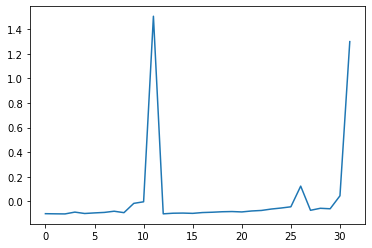

In [ ]:
plt.plot([info['ppo/loss/policy'][0] for info in batch_info])

In [ ]:
allow_all = t.ones(tokenizer.vocab_size).bool()
text = generate(gen_model, query_tensor, allow_all, txt_len=22)

In [ ]:
text

tensor([[    6,  2612,  2612,  2612,  2612,  2612,  2612,  2612,  2612, 11954,
          2612,  2612,  2612, 11954,  2612,  2612, 11954,  2612, 11954,  2612,
         11954,  2612],
        [    6,  2612,  2612,  2612,  2612,  2612,  2612,  2612,  2612,  2612,
          2612,  2612,  2612,  2612,  2612,  2612,  2612,  2612,  2612,  2612,
          2612,  2612],
        [    6,  2612,  2612,  2612,  2612,  2612,  2612,  2612,  2612,  2612,
          2612,  2612, 11954,  2612,  2612,  2612,  2612,  2612,  2612,  2612,
         11954,  2612],
        [    6,  2612,  2612,  2612,  2612, 11954,  2612,  2612,  2612, 11954,
          2612, 11954,  2612,  2612,  2612,  2612,  2612,  2612, 11954,  2612,
          2612, 11954],
        [    6,  2612,  2612,  2612,  2612,  2612,  2612,  2612,  2612,  2612,
          2612,  2612,  2612, 11954,  2612,  2612,  2612,  2612,  2612, 11954,
          2612, 11954],
        [    6,  2612,  2612,  2612,  2612,  2612,  2612,  2612,  2612,  2612,
          2

In [ ]:
t.sum(t.isin(text, top1000_v2.to(device)).int())

tensor(12, device='cuda:3')

## Comparing two measures of token_frequency

In [ ]:
with open("v2_tok_counts.json") as f:
    v2_dict = json.load(f)

In [ ]:
v2 = t.tensor([v2_dict.get(str(k),0) for k in range(tokenizer.vocab_size)])

In [ ]:
top1000_v2 = t.topk(v2, k=1000).indices

In [ ]:
tokenizer.decode([5,6,4])

"&'%"

In [ ]:
tokenizer.decode(sorted(top1000))

'!"#$%&\'()*+,-./0123456789:;<=>?@ABCDEFGHIJKLMNOPQRSTUVWXYZ[\\]^_`abcdefghijklmnoprstuvwxyz{|}~\n aheinreon theeratenitisanoresedingalar to of in andaslestrolyid Iet A is onimamadse that for\'s it you with 1ch as (if 2ers "em was at Theusand orabthun00el from--alloutThe\'t01..ieone." -are,"clsoint\n\n It 0 [ \'newe).. This –com =manThIn000, —up |10—...//It :12exco5019WeER11the**WhlessThis /20 )IN30St": #15appmeON +be…AT14sc16tosh1325AR18byIfButHeES17ANOR",YouforofnotbrENAs2480ISmy4022ALThereAndForback60use–".ASCh2329ED27AnITWhat26289933IC70200REOntrWhen45ACST35likeAlIDAMOTSo6475","How21ShwwwThatToLE3844Cl3632="OS39340537PhBC48Ad665547ADTr084909USNoAtProAPThey65070204Re10003Con68basedExUnLe3167WithArOPOneAllAfternet5906SheSc58CH()88BI46Immore57</43•newEMBlWhilePlMynameNot42FLPS::NewIssee90NowGetBeBy41\xadnoIMDonhttp54500IP98SACC>>THContSP5253BAHere51butSomewithQu8689NAAddSp2015SeIRAppTSTheseAdvertisementwhich72PRAccordingAbEn96FromHoweverclassUp")UNRes2014LevelDeCLOurManImageMoreSEOfWh

In [ ]:
tokenizer.decode(top1000_v2)

'&\'%)*(+,-05.3/6:748=1<;9eL?2BDCEAGI[XJN]@R�PKHVTFUgYWOn\\jqk^_aMdu�ipt`m��>clr} whoxhwyv�Zoill�S����"#��ɾ~���f��{he��� you�|Ӣ��z do�թ�s�������� comp\u05f9��� wor\x02Q����Ͷ�����\u07ba\x01� g��\x00��an\x11The�����\x03\x0c\x05���ge�� tra����\x16 there��ain�ort��etb\ton�am\x0e\x07���\x0fيia Scott� the�\x08�\x17\x0b��\x14 inher�\x1c\x1b��\x06�\x15� t��\r�ۀ\x10�ar a�\x1e� St�al����\x1d\x13art\x18 re ser S and reik N��ll nowld Aions complethir\x19 Uemle�\x04 Bowidredun (ubateuric� on I� f\x7fif J__ 1� p will behch Tat--ac can l scop�ra�ormendol an at e�ospe F have yin because is n Leit Oorimies or conost� L\'s\x1f j we itag thisve 5du o de againstizeix His bentcimericpp m G thatot foreringregap$ccame dist disib In kn leumod wh ab14 of�rawn makeut shpl don withompt our not as byingft Theast be01\nour 2 fromings se w� pl alel allide st onlyideo�antithokongvern comould wereersich toighul becseayallyas\x1a ne teab thoseest�ackaryntewkereeatesiveomeoselic wieldedimeInans unall M off itsentsrom r

In [ ]:
tokenizer.decode(t.isin(top1000,top1000_v2).nonzero().flatten())

'!"#$%&\')+,-./012345679:<=>?@CDFGHKLOPQUWX_bdefghjlmnquwxy�������������������������������������\x02\x06\x12\x15\x16\x1b\x1c\x1d\x1e ������ ton theenesingar m ofic th re g I isimamay for u asers W r Fulromess Eort this O pl dorou jffions K theirber had,"au wouldereite resailough than part kn newentsove prearkamp playhingject see fl Unoss Reific 10 reg veryotheroth==uringativeerson endful acself min—alk here world'

In [ ]:
len(t.isin(top1000,top1000_v2).nonzero().flatten())

196